# This notebook tests the effect of FoF predictions by adding the SBRL features to the adherence assay

In [1]:
from PE_eda.preproc import adherence_data
from PE_eda.eda import adherence
import sys
sys.path.append("../..")
import pandas as pd
import numpy as np
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.rocklin_models import logistic_classifier
from harness.th_model_instances.perovskite_models.xgboost import gradient_boosted_tree
from harness.th_model_instances.hamed_models.navie_bayes import gaussian_naive_bayes_classification
from src.models.ML_functions import plot_leaderboard, run_ml
from src.models.baseline_ML_functions import common_name_to_genus_speices, get_max_accuracy
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sys import platform 
prefix = '../../data_files/'
prefixG = '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
old_a549, feature_cols1 = adherence_data.process_a549_files([prefix + 'old_ivv_A549'])
new_a549, feature_cols2 = adherence_data.process_a549_files([prefix + 'new_ivv_A549'])
a549_joined = pd.concat([old_a549, new_a549]).reset_index(drop = True)

In [5]:
# Load CDC embedding features 
post_train_mean2 = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/cdc_post_train_emb2.csv', index_col = 0)

In [6]:
name_mapping = common_name_to_genus_speices()
a549_joined['genus_species'] = a549_joined['Common Name'].map(name_mapping)

In [8]:
a549_w_cdc = pd.merge(a549_joined, post_train_mean2, left_on = 'genus_species', right_index = True)

In [9]:
th_path = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/adherence/adherence_w_cdc_Apr25'
a549_w_cdc.Foe = a549_w_cdc.Foe.astype(int)

# Adherence features only (control)

In [48]:
run_ml(a549_w_cdc, 'adh_no_cdc1',feature_cols_to_use=feature_cols1, 
       models_to_test = [logistic_classifier, gaussian_naive_bayes_classification, random_forest_classification, gradient_boosted_tree],
       output_dir = th_path, repeat = 10, 
       feature_cols_to_normalize=feature_cols1, sparse_cols_to_use=None, percents = [0.3,0.4,0.5,0.6,0.7])


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:19:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 14:19:50. Total run time = 0.22 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gaussian_naive_bayes_classification at time 14:19:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.00 seconds
Run finished at 14:19:50. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------

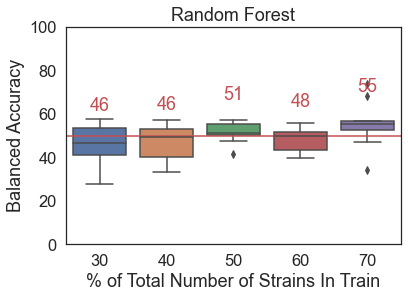

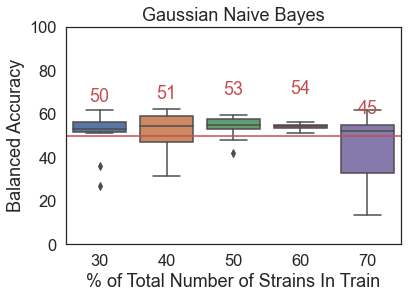

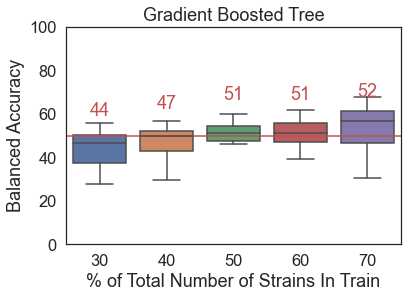

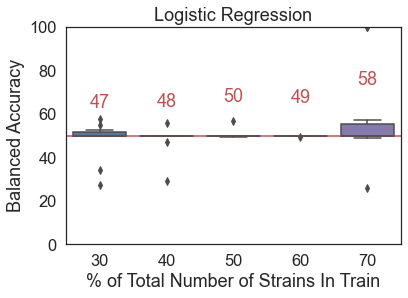

In [8]:
get_max_accuracy('adh_no_cdc1', th_path)
plot_leaderboard('adh_no_cdc1', th_path, print_acc = True)

# Adherence features + CDC binary features (no embedding)

In [13]:
cdc_features = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/processed_cdc_data.csv', index_col = 0)

In [14]:
cdc_features['instance_sum'] = scaler.fit_transform(
        cdc_features['instance_sum'].values.reshape(len(cdc_features),1))

In [15]:
a549_w_cdc_no_emb = pd.merge(a549_w_cdc, cdc_features, left_on = 'genus_species', right_index = True)
a549_w_cdc_no_emb.Foe = a549_w_cdc_no_emb.Foe.astype(int)

In [17]:
no_emb_path = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/adherence/Adh_w_cdc_Sep21'
w_cdc_feature_cols = feature_cols1 + cdc_features.columns.to_list()

In [30]:
run_ml(a549_w_cdc_no_emb, 'adh_cdc_no_emb1',feature_cols_to_use=w_cdc_feature_cols, 
       models_to_test = [logistic_classifier, gaussian_naive_bayes_classification, random_forest_classification, gradient_boosted_tree],
       output_dir = no_emb_path, repeat = 10, feature_cols_to_normalize=w_cdc_feature_cols, 
       sparse_cols_to_use=None, percents = [0.3,0.4,0.5,0.6,0.7])


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 17:52:45
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.00 seconds
Run finished at 17:52:46. Total run time = 0.31 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gaussian_naive_bayes_classification at time 17:52:46
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 17:52:46. Total run time = 0.26 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------

In [33]:
get_max_accuracy('adh_cdc_no_emb1', no_emb_path)

(Description           Model Name         
 adh_cdc_no_emb1__0.7  logistic_classifier    60.9
 Name: Balanced Accuracy, dtype: float64,
 Description           Model Name         
 adh_cdc_no_emb1__0.7  logistic_classifier    14.0
 Name: Balanced Accuracy, dtype: float64)

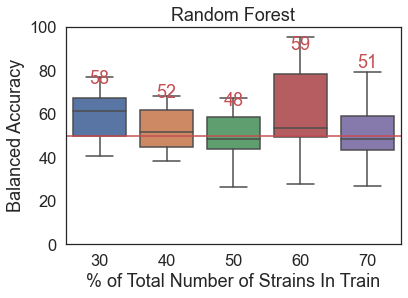

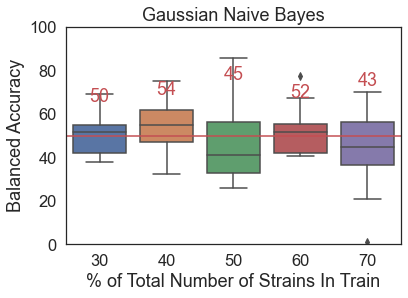

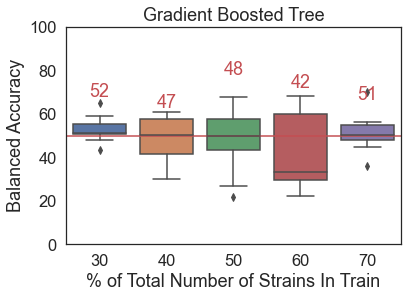

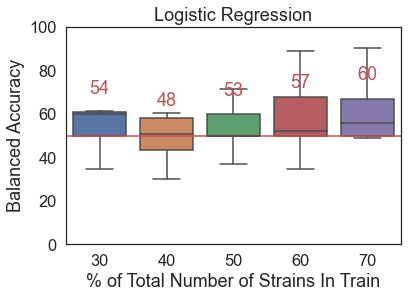

In [37]:
plot_leaderboard('adh_cdc_no_emb1', no_emb_path, print_acc = True)

# Adherence features + CDC embedding (binary test features)

In [20]:
feature_cols_w_cdc = feature_cols1 + post_train_mean2.columns.tolist()

In [48]:
run_ml(a549_w_cdc, 'adh_w_cdc1',feature_cols_to_use=feature_cols_w_cdc, 
       models_to_test = [logistic_classifier, gaussian_naive_bayes_classification, random_forest_classification, gradient_boosted_tree],
       output_dir = th_path, repeat = 10, 
       feature_cols_to_normalize=feature_cols_w_cdc, sparse_cols_to_use=None, percents = [0.3,0.4,0.5,0.6,0.7])


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:19:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 14:19:50. Total run time = 0.22 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gaussian_naive_bayes_classification at time 14:19:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.00 seconds
Run finished at 14:19:50. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------

In [23]:
get_max_accuracy('adh_w_cdc1', th_path)

Description      Model Name         
adh_w_cdc1__0.4  logistic_classifier    65.7
Name: Balanced Accuracy, dtype: float64


(Description      Model Name         
 adh_w_cdc1__0.4  logistic_classifier    65.7
 Name: Balanced Accuracy, dtype: float64,
 Description      Model Name         
 adh_w_cdc1__0.4  logistic_classifier    12.4
 Name: Balanced Accuracy, dtype: float64)

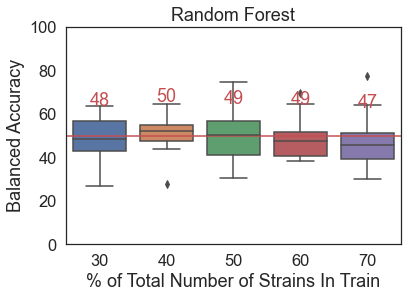

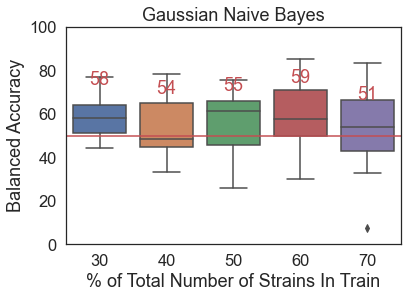

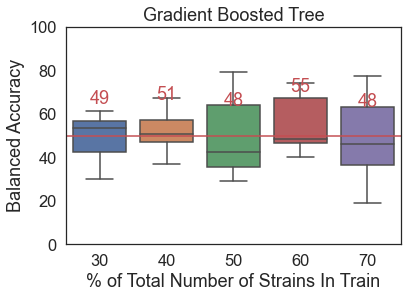

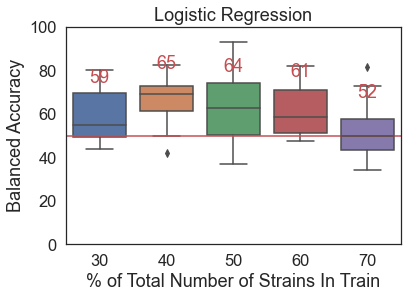

In [10]:
plot_leaderboard('adh_w_cdc1', th_path, print_acc = True)